# Tokyo Stock Prices - A. Foster, M. Staniszewski

Our project is related to **time series forecasting** of financial product prices using advanced machine learning models - [Facebook Prophet](https://facebook.github.io/prophet/) and [Uber Orbit](https://github.com/uber/orbit). Our work is [stored on GitHub](https://github.com/afoster28/ml_fin2) in a public repository along with the dataset itself.  

## About the Data

[The dataset (link to Kaggle)](https://www.kaggle.com/competitions/jpx-tokyo-stock-exchange-prediction/data) contains a list of time series of stock and option prices traded in the Japanese market. The original goal of the exercise was to predict returns, but as this is fully equivalent to predicting the price itself, we decided to chose the latter in favor of price **non-negativity** and **non-stationarity** of observations.

$$return_i = \frac{price_i}{price_{i-1}} - 1$$

### Company of Choice

The focus of our work was a selected stock in the Japanese market: **"Japan Petroleum Exploration Co.,Ltd."**. This is a domestic company operating in the *energy* sector and focused on mining. Restricting our dataset this way allowed us to reduce its original, very significant size.

## Forecasting Period

As stock prices are generally very dificult to predict, we opted for a (still very impressive) forcasting period of 15 days, which correspond to three business weeks. In our initial expectations we thought, that an accurate prediction that far into the future is not possible, so that time frame was a suitable test of the forecasting libraries that we explored.

# Loading and Preparing Data

We first need to load the dataset into the memory of the program. Please note that you can either download the dataset from Kaggle (link in above sections) or pull it from our repository, which stores it using `git lfs` ([Large File Storage](https://git-lfs.com/)).

## Installing and Importing Libraries

If you decide to work in [Google Colab](https://colab.research.google.com/) (like we did) you will need to install some libraries before importing them. Notably, **the stable version of Orbit is not working in Colab**, so you need to explicitly specify the unstable version during the install.

In [ ]:
!pip install prophet # Install Facebook Prophet
!pip install git+https://github.com/uber/orbit.git@dev # Install the dev version of Orbit

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from pylab import rcParams
# Facebook Prophet:
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from prophet.diagnostics import cross_validation
from prophet.plot import plot_cross_validation_metric
# Uber Orbit:
import orbit
from orbit.models import ETS, LGT, DLT
from orbit.diagnostics.plot import plot_predicted_data

In [4]:
FORECASTING_PERIOD = 15

In [5]:
data = pd.read_csv('stock_prices.csv')
data = data.loc[lambda row: row['SecuritiesCode'] == 1662].fillna(method="bfill")
data = data.set_index('Date')
full = data.copy()
data = data.head(len(data) - FORECASTING_PERIOD) # Train set - test set embedded in 'full'
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1187 entries, 2017-01-04 to 2021-11-11
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   RowId             1187 non-null   object 
 1   SecuritiesCode    1187 non-null   int64  
 2   Open              1187 non-null   float64
 3   High              1187 non-null   float64
 4   Low               1187 non-null   float64
 5   Close             1187 non-null   float64
 6   Volume            1187 non-null   int64  
 7   AdjustmentFactor  1187 non-null   float64
 8   ExpectedDividend  1155 non-null   float64
 9   SupervisionFlag   1187 non-null   bool   
 10  Target            1187 non-null   float64
dtypes: bool(1), float64(7), int64(2), object(1)
memory usage: 103.2+ KB


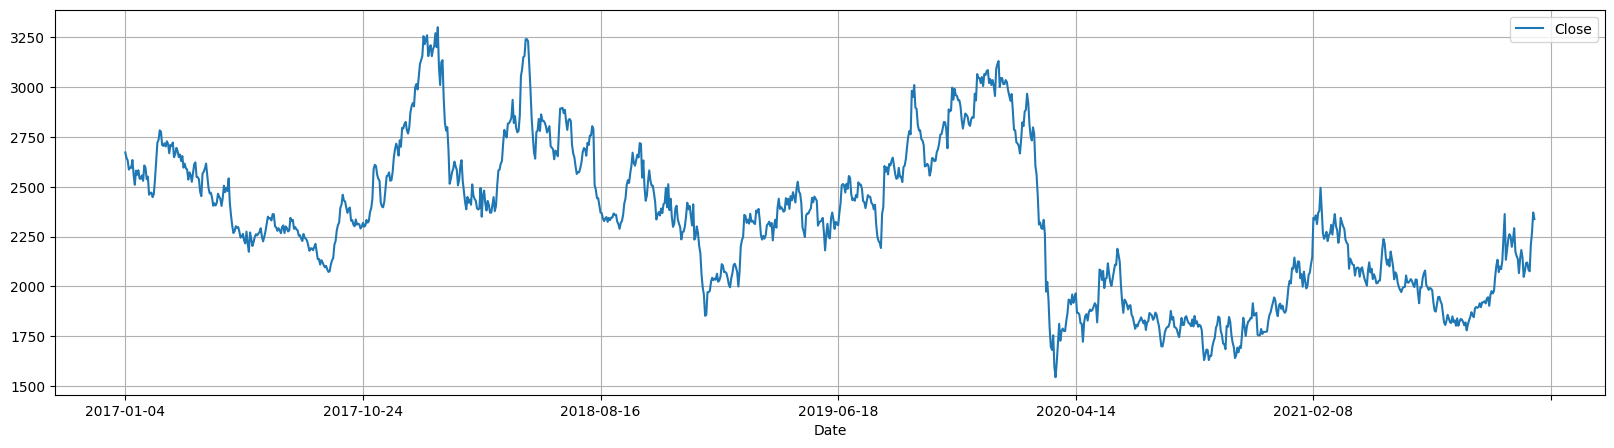

In [4]:
series = data[['Close']]
series.plot(grid=True,figsize=(20,5))
plt.show()

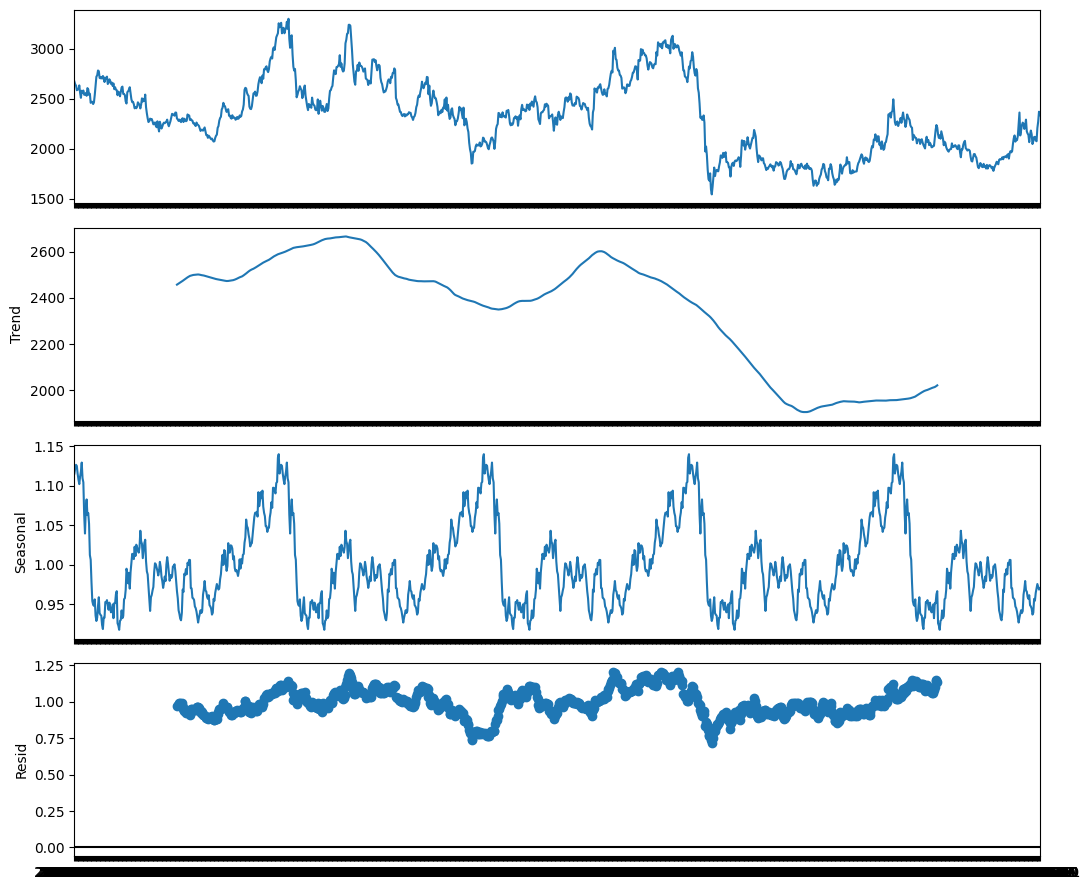

In [5]:

rcParams['figure.figsize'] = 11, 9
decomposition = sm.tsa.seasonal_decompose(series,
                                          model = 'multiplicative',
                                          period=252)
fig = decomposition.plot()
plt.show()

In [6]:
s = series.reset_index()
s.columns = [ 'ds', 'y' ]
s.head()

,ds,y
0,2017-01-04,2672.0
1,2017-01-05,2645.0
2,2017-01-06,2632.0
3,2017-01-10,2586.0
4,2017-01-11,2596.0


In [7]:
#!pip install prophet


m = Prophet(interval_width=0.95) #by default is 80%
m.add_country_holidays(country_name='JP')
model = m.fit(s)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpf5wtxbh4/yt9xizfo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpf5wtxbh4/gaxrm6mf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19601', 'data', 'file=/tmp/tmpf5wtxbh4/yt9xizfo.json', 'init=/tmp/tmpf5wtxbh4/gaxrm6mf.json', 'output', 'file=/tmp/tmpf5wtxbh4/prophet_modelf8y3k409/prophet_model-20240114192514.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:25:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:25:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [8]:
future = m.make_future_dataframe(periods=15)
future.tail()

,ds
1197,2021-11-22
1198,2021-11-23
1199,2021-11-24
1200,2021-11-25
1201,2021-11-26


In [9]:
forecast = m.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Autumnal Equinox,Autumnal Equinox_lower,Autumnal Equinox_upper,Children's Day,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1197,2021-11-22,2239.992891,1931.579081,2530.960016,2235.262083,2247.315247,0.0,0.0,0.0,0.0,...,-26.332443,-26.332443,-26.332443,26.684000,26.684000,26.684000,0.0,0.0,0.0,2240.344448
1198,2021-11-23,2240.940792,1938.225185,2557.420163,2235.316861,2249.316543,0.0,0.0,0.0,0.0,...,-26.663243,-26.663243,-26.663243,29.013350,29.013350,29.013350,0.0,0.0,0.0,2243.290900
1199,2021-11-24,2241.888694,1934.317798,2543.888241,2233.255700,2251.601049,0.0,0.0,0.0,0.0,...,-26.371790,-26.371790,-26.371790,31.652838,31.652838,31.652838,0.0,0.0,0.0,2247.169741
1200,2021-11-25,2242.836595,1953.544375,2545.242861,2233.465316,2253.470136,0.0,0.0,0.0,0.0,...,-30.837279,-30.837279,-30.837279,34.613780,34.613780,34.613780,0.0,0.0,0.0,2246.613096
1201,2021-11-26,2243.784497,1943.883141,2533.788303,2231.140778,2255.363465,0.0,0.0,0.0,0.0,...,-31.128930,-31.128930,-31.128930,37.896593,37.896593,37.896593,0.0,0.0,0.0,2250.552160


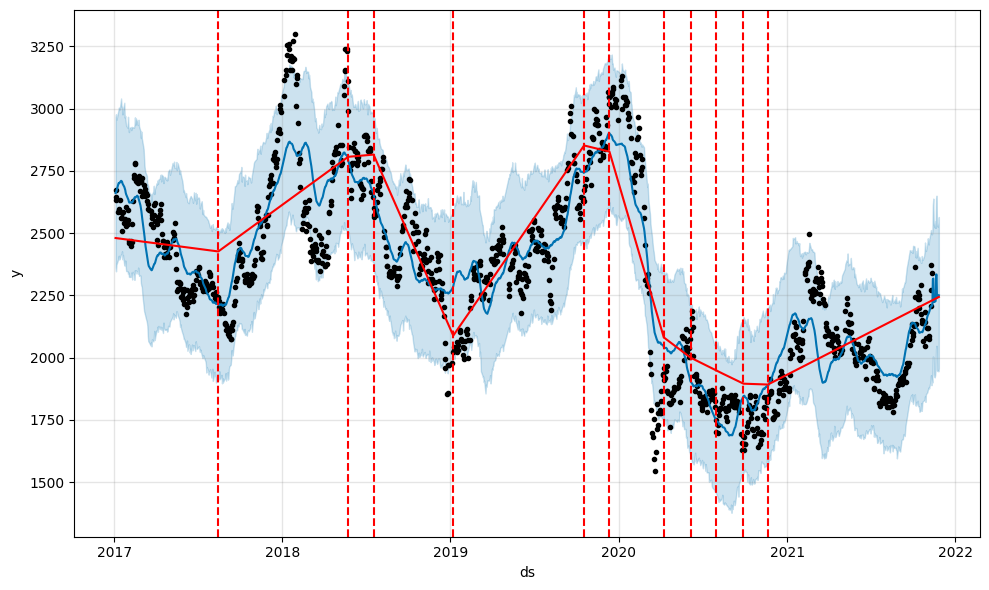

In [158]:

plot1 = m.plot(forecast)
a = add_changepoints_to_plot(plot1.gca(),m,forecast)

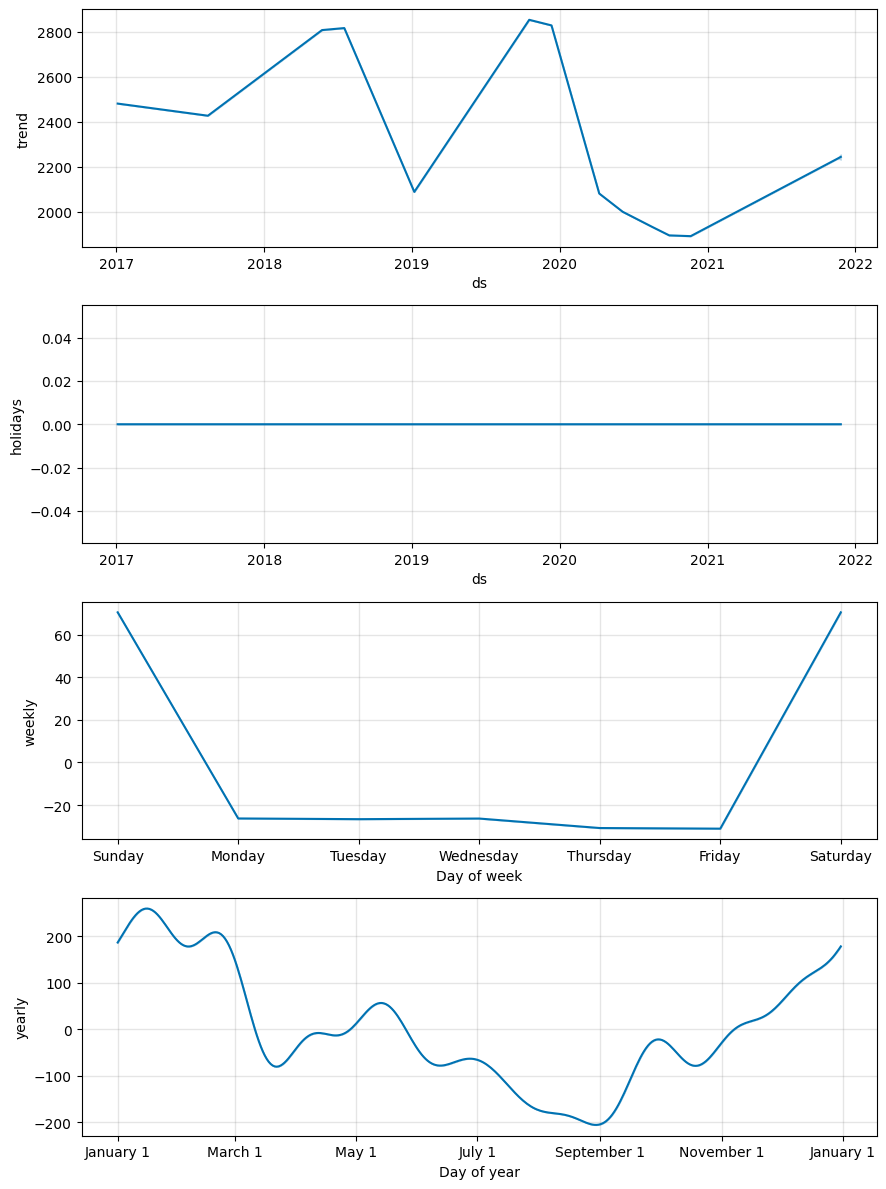

In [10]:
plot2 = m.plot_components(forecast)

In [11]:
full['ds'] = pd.to_datetime(full.index, utc = True)
forecast['ds'] = pd.to_datetime(forecast['ds'], utc = True)
df_merge = pd.merge(full, forecast[['ds','yhat_lower','yhat_upper','yhat']], on='ds')
df_merge = df_merge[['ds','yhat_lower','yhat_upper','yhat','Close']]
df_merge.head(FORECASTING_PERIOD)

,ds,yhat_lower,yhat_upper,yhat,Close
0,2017-01-04 00:00:00+00:00,2367.407762,2960.361140,2661.185545,2672.0
1,2017-01-05 00:00:00+00:00,2364.271689,2958.668137,2663.505850,2645.0
2,2017-01-06 00:00:00+00:00,2360.310001,2964.639472,2669.841869,2632.0
3,2017-01-10 00:00:00+00:00,2393.203942,2996.643847,2697.069726,2586.0
4,2017-01-11 00:00:00+00:00,2395.982549,2988.996207,2701.596732,2596.0
5,2017-01-12 00:00:00+00:00,2391.057498,2988.201976,2700.603412,2595.0
6,2017-01-13 00:00:00+00:00,2419.062796,2987.001566,2702.950348,2634.0
7,2017-01-16 00:00:00+00:00,2412.374189,3010.481689,2710.203019,2560.0
8,2017-01-17 00:00:00+00:00,2440.881947,3030.381232,2708.810879,2510.0
9,2017-01-18 00:00:00+00:00,2412.192525,3009.746055,2707.120538,2581.0


In [33]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
# calculate MAE between observed and predicted values
y_true = df_merge['Close'].values
y_pred = df_merge['yhat'].values
mae_01 = mean_absolute_error(y_true, y_pred)
print('MAE: %.3f' % mae_01)
mape_01 = mean_absolute_percentage_error(y_true, y_pred)
print('MAPE: %.3f' % mape_01)

KeyError: 'yhat'

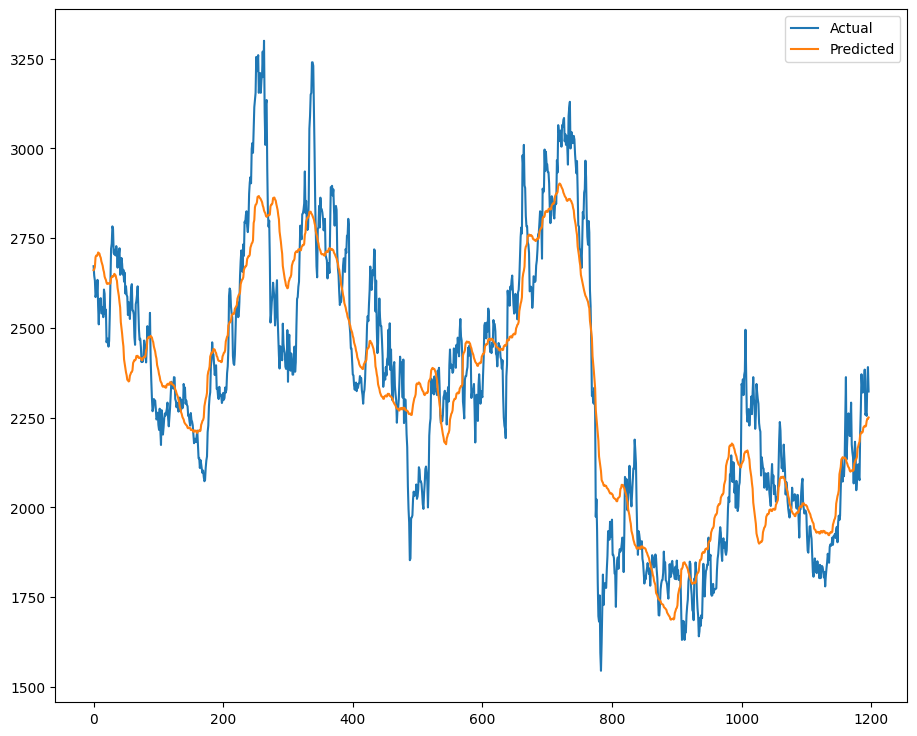

In [13]:
# plot expected vs actual
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

In [14]:

#df_cv = cross_validation(m)
df_cv = cross_validation(m, initial='800 days', period='1 day', horizon = '15 days', parallel='threads')


Streaming output truncated to the last 5000 lines.
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73690', 'data', 'file=/tmp/tmpf5wtxbh4/xc7qyrt3.json', 'init=/tmp/tmpf5wtxbh4/e9rpqzht.json', 'output', 'file=/tmp/tmpf5wtxbh4/prophet_modelu5bb1pwm/prophet_model-20240114192841.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:28:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:28:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpf5wtxbh4/6avutm_o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35902', 'data', 'file=/tmp/tmpf5wtxbh4/7ubnsgku.json', 'init=/tmp/tmpf5wtxbh4/6avutm_o.json', 'output', 'file=/tmp/tmpf5wtxbh4/

In [15]:
df_cv.tail()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
9554,2021-11-05,2181.311405,1871.996567,2481.587037,2076.0,2021-10-27
9555,2021-11-08,2196.838983,1849.188475,2510.986523,2208.0,2021-10-27
9556,2021-11-09,2198.672616,1878.540758,2535.764951,2272.0,2021-10-27
9557,2021-11-10,2201.138139,1900.943084,2510.597673,2371.0,2021-10-27
9558,2021-11-11,2199.331188,1872.375882,2519.227504,2338.0,2021-10-27


In [16]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.tail()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
9,11 days,84017.839973,289.858310,205.207981,0.098166,0.070092,0.096928,0.793402
10,12 days,86733.848920,294.506110,207.965947,0.099522,0.076411,0.098244,0.788592
11,13 days,88869.233031,298.109431,210.326984,0.100701,0.082491,0.099361,0.783881
12,14 days,91559.816771,302.588527,213.216810,0.102145,0.079834,0.100715,0.777601
13,15 days,95427.874356,308.914024,217.434149,0.104251,0.091156,0.102714,0.771322


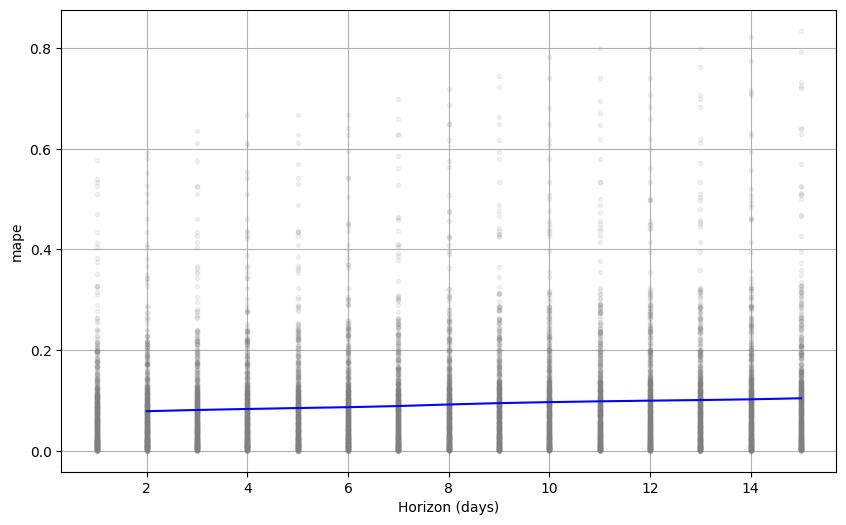

In [17]:

plot4 = plot_cross_validation_metric(df_cv, metric='mape')

In [18]:
import json
from prophet.serialize import model_to_json, model_from_json
with open('prophet_model.json', 'w') as fout:
    json.dump(model_to_json(m), fout)  # Save model

In [146]:
# Python
import itertools

param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.2, 0.5],
    'seasonality_prior_scale': [0.001, 0.01, 0.1, 1.0, 5.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
maes = []  # Store the MAE for each params here
mapes = [] # Store the MAPE for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(s)  # Fit model with given params
    df_cv = cross_validation(m, horizon='90 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    maes.append(df_p['mae'].values[0])
    mapes.append(df_p['mape'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['mae'] = maes
tuning_results['mape'] = mapes

Streaming output truncated to the last 5000 lines.
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62618', 'data', 'file=/tmp/tmpd9b4f1a5/_z_hdf3q.json', 'init=/tmp/tmpd9b4f1a5/_bt0knwg.json', 'output', 'file=/tmp/tmpd9b4f1a5/prophet_modeli07ewi2e/prophet_model-20240114175637.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:56:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:56:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
17:56:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd9b4f1a5/xsnfv5f7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd9b4f1a5/rjd4yg9x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd9b4f1a5/1jheh12f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan

In [148]:
tuning_results_df = pd.DataFrame(tuning_results)
tuning_results_df.sort_values(['mape','mae'])

,changepoint_prior_scale,seasonality_prior_scale,mae,mape
0,0.001,0.001,263.269480,0.120322
19,0.200,0.010,290.685057,0.130359
25,0.500,0.010,300.318880,0.135155
13,0.100,0.010,317.203895,0.142649
22,0.200,5.000,335.041314,0.149387
20,0.200,0.100,337.146059,0.149985
21,0.200,1.000,337.780878,0.150196
23,0.200,10.000,345.095835,0.153423
26,0.500,0.100,352.670108,0.156474
1,0.001,0.010,342.193088,0.157963


In [151]:
best_params = all_params[np.argmin(mapes)]
print(best_params)

{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.001}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd9b4f1a5/exo_2iia.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd9b4f1a5/yz7g1ez_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42829', 'data', 'file=/tmp/tmpd9b4f1a5/exo_2iia.json', 'init=/tmp/tmpd9b4f1a5/yz7g1ez_.json', 'output', 'file=/tmp/tmpd9b4f1a5/prophet_modeln2348s2q/prophet_model-20240114180445.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:04:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:04:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


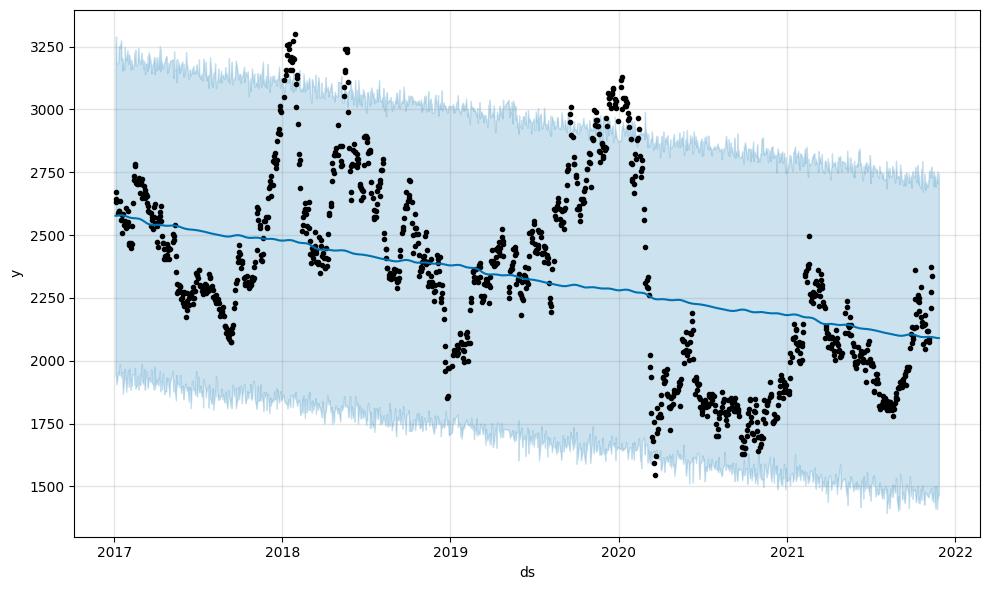

In [154]:
m = Prophet(interval_width=0.95,
            changepoint_prior_scale=best_params['changepoint_prior_scale'],
            seasonality_prior_scale=best_params['seasonality_prior_scale'])
model = m.fit(s)
future = m.make_future_dataframe(periods=FORECASTING_PERIOD)
forecast = m.predict(future)
plot5 = m.plot(forecast)

In [36]:
#!pip install cmdstanpy
#!ls /usr/local/lib/python3.10/dist-packages/orbit/stan


  Cloning https://github.com/uber/orbit.git (to revision dev) to /tmp/pip-req-build-qooblrhd
  Running command git clone --filter=blob:none --quiet https://github.com/uber/orbit.git /tmp/pip-req-build-qooblrhd
  Resolved https://github.com/uber/orbit.git to commit f99378d4c4a0b73dfde993750d606f3d0da807c5
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for orbit-ml: filename=orbit_ml-1.1.4.3-py3-none-linux_x86_64.whl size=203788765 sha256=6e8ea0dfcd15b8337acc7fd6aa10577098098bfdd9054888113cdaf05e68572a
  Stored in directory: /tmp/pip-ephem-wheel-cache-7zhfidre/wheels/87/fa/88/b2e6f9449939ead96b4b3ba6943bd9da44477820102a5cdf1d
Successfully built orbit-ml
  Attempting uninstall: orbit-ml
    Found existing installation: orbit-ml 1.1.4.2
    Uninstalling orbit-ml-1.1.4.2:
      Successfully uninstalled orbit-ml-1.1.4.2


In [1]:
#!pip install orbit-ml


In [6]:
full['Date'] = full.index
train_df = full[:-FORECASTING_PERIOD]
test_df = full[-FORECASTING_PERIOD:]

In [7]:
lgt = LGT(
    response_col='Close',
    date_col='Date',
    estimator='stan-map',
    seasonality=365,
    seed=8888,
)
lgt.fit(df=train_df)

2024-01-14 20:04:58 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.
INFO:orbit:Optimizing (PyStan) with algorithm: LBFGS.
/usr/local/lib/python3.10/dist-packages/orbit/forecaster/forecaster.py:290: UserWarning: Datetime index is not evenly distributed
  warnings.warn("Datetime index is not evenly distributed")


In [8]:

dlt = DLT(
    response_col='Close',
    date_col='Date',
    estimator='stan-map',
    seasonality=52,
    seed=8888,
    global_trend_option='linear',
    # for prediction uncertainty
    n_bootstrap_draws=1000,
)

dlt.fit(df=train_df)

2024-01-14 20:05:06 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.
INFO:orbit:Optimizing (PyStan) with algorithm: LBFGS.
/usr/local/lib/python3.10/dist-packages/orbit/forecaster/forecaster.py:290: UserWarning: Datetime index is not evenly distributed
  warnings.warn("Datetime index is not evenly distributed")


In [9]:
ets = ETS(
    response_col='Close',
    date_col='Date',
    seasonality=360, #yearly
    seed=2024,
    estimator="stan-mcmc",
    stan_mcmc_args={'show_progress': True},
)

ets.fit(df=train_df)

/usr/local/lib/python3.10/dist-packages/orbit/forecaster/forecaster.py:290: UserWarning: Datetime index is not evenly distributed
  warnings.warn("Datetime index is not evenly distributed")
2024-01-14 20:05:16 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

In [23]:
predicted_df = ets.predict(df=test_df)

/usr/local/lib/python3.10/dist-packages/orbit/forecaster/forecaster.py:335: UserWarning: Datetime index is not evenly distributed
  warnings.warn("Datetime index is not evenly distributed")


In [16]:
predicted_df.head()

,prediction_5,prediction,prediction_95
Date,,,
2021-11-12,2226.046835,2349.751299,2464.015489
2021-11-15,2207.850581,2356.492581,2461.010354
2021-11-16,2187.870554,2349.524899,2459.093537
2021-11-17,2153.921632,2331.070988,2479.387000
2021-11-18,2156.682118,2326.928211,2513.241567


In [31]:
full['ds'] = pd.to_datetime(full.index, utc = True)
predicted_df['ds'] = pd.to_datetime(predicted_df['Date'], utc = True)

df_merge = pd.merge(full, predicted_df, on='ds')
df_merge = df_merge[['ds','prediction', 'Close']]
df_merge.head(FORECASTING_PERIOD)


,ds,prediction,Close
0,2021-11-12 00:00:00+00:00,2350.486912,2320.0
1,2021-11-15 00:00:00+00:00,2345.852864,2339.0
2,2021-11-16 00:00:00+00:00,2345.626431,2339.0
3,2021-11-17 00:00:00+00:00,2346.162685,2384.0
4,2021-11-18 00:00:00+00:00,2349.133930,2258.0
5,2021-11-19 00:00:00+00:00,2347.892367,2263.0
6,2021-11-22 00:00:00+00:00,2336.294186,2255.0
7,2021-11-24 00:00:00+00:00,2337.510994,2352.0
8,2021-11-25 00:00:00+00:00,2334.868540,2391.0
9,2021-11-26 00:00:00+00:00,2362.808556,2323.0


In [35]:
y_true = df_merge['Close'].values
y_pred = df_merge['prediction'].values
mae_01 = mean_absolute_error(y_true, y_pred)
print('MAE: %.3f' % mae_01)
mape_01 = mean_absolute_percentage_error(y_true, y_pred)
print('MAPE: %.3f' % mape_01)

MAE: 43.445
MAPE: 0.019
